In [1]:
import os
from typing import Any

from pydantic import BaseModel
from unstructured.partition.pdf import partition_pdf
import json
# import tesseract
import pytesseract
from typing import *
from box import ConfigBox
from pathlib import Path
import re, sys, os
from functools import partial



import io
import os
import base64
import numpy as np
from PIL import Image
from langchain.chat_models import ChatOpenAI


import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever


from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser



/Users/goldyrana/miniconda3/envs/bounce/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [6]:
from dotenv import load_dotenv
from langchain_openai import OpenAIEmbeddings
from dataclasses import dataclass
from zipfile import ZipFile
import os
load_dotenv()

True

In [7]:
os.getcwd()

'/Users/goldyrana/mess/deep_learning/projects/rag/backend/notebooks'

In [8]:
os.chdir("../"), os.getcwd()

(None, '/Users/goldyrana/mess/deep_learning/projects/rag/backend')

In [9]:
from unstructured.documents.elements import CompositeElement, Table, Image, ListItem  # Import ListItem

from backend.src.utils.common import *
from backend.logger import logger
from backend.src.constants import *

In [10]:
from backend.src.storage.chroma_storage import VectorDatabase
from backend.src.config.configuration import ConfigurationManager

In [11]:
config_manager = ConfigurationManager(CONFIG_FILE_PATH, PARAMS_FILE_PATH)
vb_params = config_manager.get_vectordatabase_config()
print(vb_params)
vb = VectorDatabase(vb_params)
vectorstore = vb.init_chromadb(OpenAIEmbeddings())

retriever = vb.get_multivector_retriever(vectorstore, id_key="doc_id")


2025-02-10 21:08:51,296 - root - INFO - Yaml read successfully from ../config.yaml
2025-02-10 21:08:51,298 - root - INFO - Yaml read successfully from ../params.yaml
2025-02-10 21:08:51,302 - root - ERROR - Exception occured while reading yaml file from                         location: ../params.yaml
 First argument must be mapping or iterable
2025-02-10 21:08:51,403 - chromadb.telemetry.product.posthog - INFO - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
2025-02-10 21:08:51,506 - chromadb.config - DEBUG - Starting component System


VectorDatabaseConfig(vectorstore_name='test4', persist_directory='db')


2025-02-10 21:08:51,506 - chromadb.config - DEBUG - Starting component Posthog
2025-02-10 21:08:51,507 - chromadb.config - DEBUG - Starting component OpenTelemetryClient
2025-02-10 21:08:51,507 - chromadb.config - DEBUG - Starting component SqliteDB
2025-02-10 21:08:51,512 - chromadb.config - DEBUG - Starting component SimpleQuotaEnforcer
2025-02-10 21:08:51,513 - chromadb.config - DEBUG - Starting component SimpleRateLimitEnforcer
2025-02-10 21:08:51,513 - chromadb.config - DEBUG - Starting component LocalSegmentManager
2025-02-10 21:08:51,513 - chromadb.config - DEBUG - Starting component LocalExecutor
2025-02-10 21:08:51,514 - chromadb.config - DEBUG - Starting component SegmentAPI
2025-02-10 21:08:51,519 - chromadb.api.segment - DEBUG - Collection test4 already exists, returning existing collection.


# content generation

In [12]:
from backend.src.queries.handler import QueryHandler
qh = QueryHandler(retriever)
retriever = qh.get_vectorstore_as_retreiever()

In [ ]:
reterieved_docs = qh.similarity_search("what the report tells us about sales", 7)
raw_docs, metadata = qh.map_raw_docs(reterieved_docs)

2025-02-10 20:36:29,818 - openai._base_client - DEBUG - Request options: {'method': 'post', 'url': '/embeddings', 'files': None, 'post_parser': <function Embeddings.create.<locals>.parser at 0x1278efc10>, 'json_data': {'input': [[12840, 279, 1934, 10975, 603, 922, 6763]], 'model': 'text-embedding-ada-002', 'encoding_format': 'base64'}}
2025-02-10 20:36:29,820 - openai._base_client - DEBUG - Sending HTTP Request: POST https://api.openai.com/v1/embeddings
2025-02-10 20:36:29,820 - httpcore.connection - DEBUG - connect_tcp.started host='api.openai.com' port=443 local_address=None timeout=None socket_options=None
2025-02-10 20:36:29,895 - httpcore.connection - DEBUG - connect_tcp.complete return_value=<httpcore._backends.sync.SyncStream object at 0x3268dac70>
2025-02-10 20:36:29,896 - httpcore.connection - DEBUG - start_tls.started ssl_context=<ssl.SSLContext object at 0x326490940> server_hostname='api.openai.com' timeout=None
2025-02-10 20:36:29,919 - httpcore.connection - DEBUG - start_t

In [13]:
qh.split_image_text_types(reterieved_docs)

{'images': ['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCADGA8kDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA

In [13]:
from operator import itemgetter
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda
from langchain_openai import ChatOpenAI
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.messages import HumanMessage

def prompt_func(dict):
    format_texts = "\n".join(dict["context"]["texts"])
    return [
        HumanMessage(
            content=[
                {"type": "text", "text": f"""Answer the question based only on the following context, which can include text, tables, and the below image:
                Question: {dict["question"]}

                Text and tables:
                {format_texts}
                            """},
                {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{dict['context']['images'][0]}"}},
                    ]
                    )
            ]

model = ChatOpenAI(temperature=0, model="gpt-4o", max_tokens=1024)

# RAG pipeline
retriever
chain = (
    {"context": retriever | RunnableLambda(QueryHandler.split_image_text_types), "question": RunnablePassthrough()}
    | RunnableLambda(prompt_func)
    | model
    | StrOutputParser()
)

2025-02-10 21:13:31,787 - openai._base_client - DEBUG - Request options: {'method': 'post', 'url': '/embeddings', 'files': None, 'post_parser': <function Embeddings.create.<locals>.parser at 0x131967040>, 'json_data': {'input': [[12840, 1934, 3371, 603, 922, 949, 220]], 'model': 'text-embedding-ada-002', 'encoding_format': 'base64'}}
2025-02-10 21:13:31,853 - openai._base_client - DEBUG - Sending HTTP Request: POST https://api.openai.com/v1/embeddings
2025-02-10 21:13:31,856 - httpcore.connection - DEBUG - close.started


2025-02-10 21:13:31,977 - httpcore.connection - DEBUG - close.complete
2025-02-10 21:13:31,978 - httpcore.connection - DEBUG - connect_tcp.started host='api.openai.com' port=443 local_address=None timeout=None socket_options=None
2025-02-10 21:13:32,059 - httpcore.connection - DEBUG - connect_tcp.complete return_value=<httpcore._backends.sync.SyncStream object at 0x137d402e0>
2025-02-10 21:13:32,060 - httpcore.connection - DEBUG - start_tls.started ssl_context=<ssl.SSLContext object at 0x33047de40> server_hostname='api.openai.com' timeout=None
2025-02-10 21:13:32,092 - httpcore.connection - DEBUG - start_tls.complete return_value=<httpcore._backends.sync.SyncStream object at 0x3308ee250>
2025-02-10 21:13:32,092 - httpcore.http11 - DEBUG - send_request_headers.started request=<Request [b'POST']>
2025-02-10 21:13:32,093 - httpcore.http11 - DEBUG - send_request_headers.complete
2025-02-10 21:13:32,093 - httpcore.http11 - DEBUG - send_request_body.started request=<Request [b'POST']>
2025-0
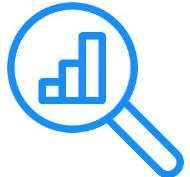

{'context': {'images': ['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCACxAL4DASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAoopM0AFMkljhjMksiog5LMcAVzHiPxvZ6OWtrYC5vB1UH5U+p9fb+VeaalrWp67OBdTyS5bKRKMKD7Afz616eEyurXXPL3Y92ebisyp0Xyx96R6bqHj3RbF2RJXunXtAMj8zgflXN

2025-02-10 21:13:39,278 - httpcore.http11 - DEBUG - receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Date', b'Mon, 10 Feb 2025 15:43:39 GMT'), (b'Content-Type', b'application/json'), (b'Transfer-Encoding', b'chunked'), (b'Connection', b'keep-alive'), (b'access-control-expose-headers', b'X-Request-ID'), (b'openai-organization', b'user-gccgvei9eaw4a1hksddpirf5'), (b'openai-processing-ms', b'5545'), (b'openai-version', b'2020-10-01'), (b'x-ratelimit-limit-input-images', b'50000'), (b'x-ratelimit-limit-requests', b'500'), (b'x-ratelimit-limit-tokens', b'30000'), (b'x-ratelimit-remaining-input-images', b'49999'), (b'x-ratelimit-remaining-requests', b'499'), (b'x-ratelimit-remaining-tokens', b'28176'), (b'x-ratelimit-reset-input-images', b'1ms'), (b'x-ratelimit-reset-requests', b'120ms'), (b'x-ratelimit-reset-tokens', b'3.648s'), (b'x-request-id', b'req_787632de8eb50031d0bbcb10dea755b5'), (b'strict-transport-security', b'max-age=31536000; includeSubDomains; preloa

In [15]:
result = chain.invoke("what report tell us about ? ")

In [16]:
result

"The report discusses forward-looking statements by a company, expressing expectations or beliefs about future results. These statements are based on management's plans and assumptions as of April 12, 2023. The report highlights that these statements are not guarantees and involve risks and uncertainties. Factors that could cause actual results to differ include changes in commodity prices, global market conditions, military conflicts, public health crises, regulatory changes, and other economic or operational challenges. The report emphasizes that actual outcomes may differ materially from the forecasts."

In [36]:
retriever.vectorstore.as_retriever().invoke("test query")

2025-02-10 20:56:11,653 - openai._base_client - DEBUG - Request options: {'method': 'post', 'url': '/embeddings', 'files': None, 'post_parser': <function Embeddings.create.<locals>.parser at 0x33d34c0d0>, 'json_data': {'input': [[1985, 3319]], 'model': 'text-embedding-ada-002', 'encoding_format': 'base64'}}
2025-02-10 20:56:11,662 - openai._base_client - DEBUG - Sending HTTP Request: POST https://api.openai.com/v1/embeddings
2025-02-10 20:56:11,664 - httpcore.connection - DEBUG - close.started
2025-02-10 20:56:11,669 - httpcore.connection - DEBUG - close.complete
2025-02-10 20:56:11,671 - httpcore.connection - DEBUG - connect_tcp.started host='api.openai.com' port=443 local_address=None timeout=None socket_options=None
2025-02-10 20:56:11,768 - httpcore.connection - DEBUG - connect_tcp.complete return_value=<httpcore._backends.sync.SyncStream object at 0x33d4ba0d0>
2025-02-10 20:56:11,774 - httpcore.connection - DEBUG - start_tls.started ssl_context=<ssl.SSLContext object at 0x32649094

[Document(id='42a4bab3-ed32-4315-8b2f-1dbae9e4a415', metadata={'doc_id': '629eba7c-f071-44e0-920a-d5034ee7fe06', 'raw_string': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCACxAL4DASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAoopM0AFMkljhjMksiog5LMcAVzHiPxvZ6O